In [244]:
import numpy as np
import pandas as pd
from nilearn.connectome import ConnectivityMeasure
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_predict, LeaveOneOut
import seaborn as sns
import matplotlib.pyplot as plt

In [245]:
df = pd.read_csv("bochum_sample_excl.csv")
# get rid of outlier (optional)
df = df[df.ID != 44]

In [246]:
def get_ts(atlas, plot=True):

    timeseries = []
    perc_scrubbed = []
    for i in df['ID']:
        ts = pd.read_csv('regional_timeseries/sub-' + '{0:03}'.format(i) + '/' + atlas + '/' + 'reg_timeseries.tsv',
                         sep='\t')
        # standardize
        ts = (ts - ts.mean()) / ts.std()
        ts = ts.fillna(0)
    
        timeseries.append(ts.values)
        
    labels = ts.columns.values

    if plot:
        # double check visually
        sub_idx=10  # modify this for a different subject
        # modify below for different regions, with their index
        pd.DataFrame(timeseries[sub_idx],columns=ts.columns.values).iloc[:, [2, 3, 4]].plot(title=atlas,
                                                                                           figsize=(10,1))
        plt.show()
        
    return timeseries, labels
        

In [247]:
def calculate_connectivity(ts, atlas, labels, plot=True):
    correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)
    X = correlation_measure.fit_transform(ts) # these are the features

    if plot:
        # double-check the mean matrix visually
        mat=correlation_measure.mean_
        #mat=mat[1:, 1:] #fisrt row and column is global signal
        mat[range(mat.shape[0]), range(mat.shape[0])] = 0 # zero diag 
        sns.heatmap(pd.DataFrame(mat,
                                columns=labels,
                                index=labels), cmap='coolwarm').set(title=atlas.split('_')[-1])
        plt.show()

    return X

In [248]:
atlases = ['_atlas_params__labelmap_params_7._name_atlas_basc',
           '_atlas_params__labelmap_params__name_atlas_destrieux',
           '_atlas_params__labelmap_params_scorr_mean.19_name_atlas_craddock',
           '_atlas_params__labelmap_params__name_atlas_aal',
           '_atlas_params__labelmap_params_rsn28._name_atlas_allen',
           '_atlas_params__labelmap_params_tcorr_mean.19_name_atlas_craddock']

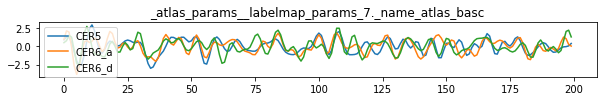

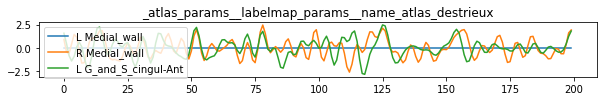

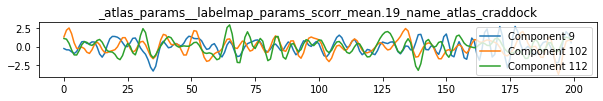

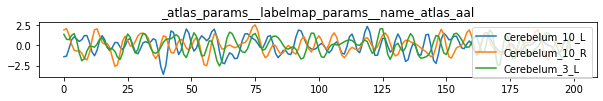

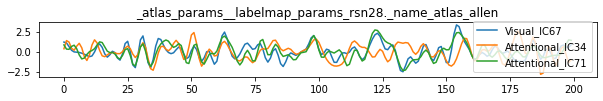

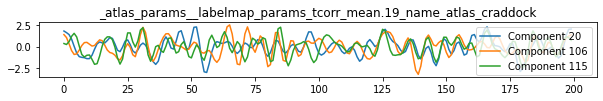

In [249]:
for a in atlases:
    ts, labels = get_ts(a)

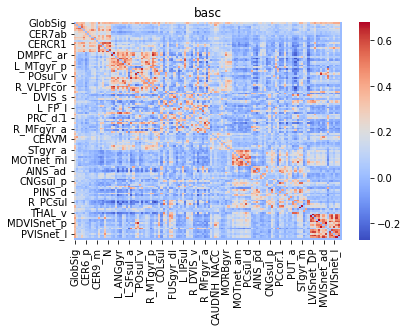

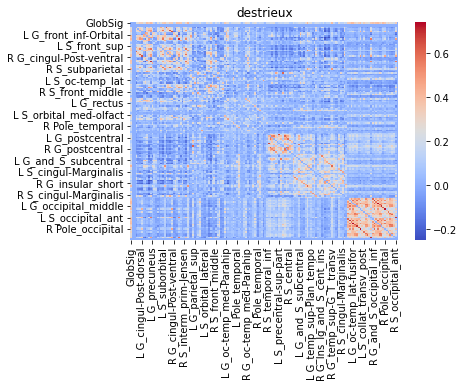

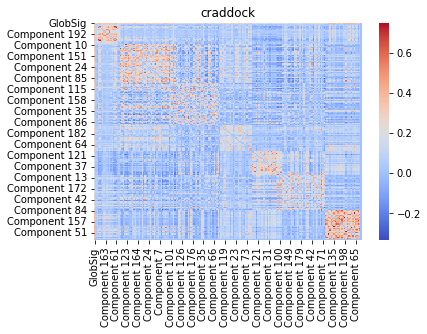

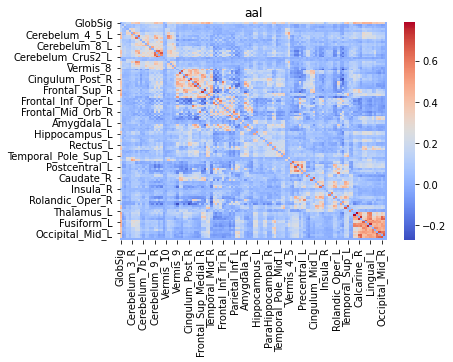

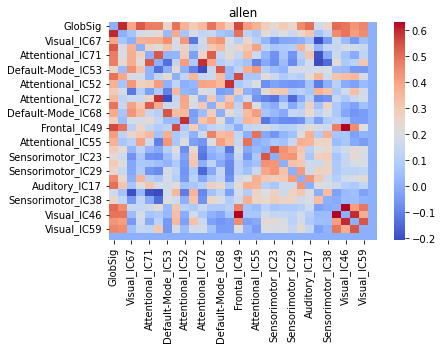

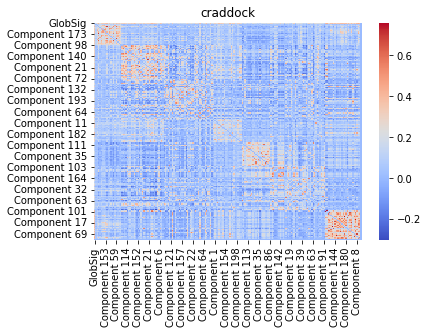

In [250]:
# look at the matrices   
for a in atlases:
    ts, labels = get_ts(a, plot=False)
    X = calculate_connectivity(ts, atlas=a, labels=labels, plot=True)


basc


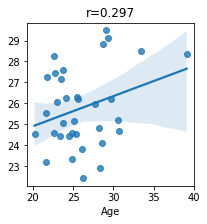

destrieux


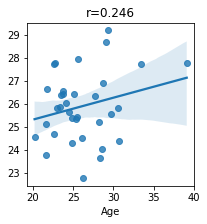

craddock


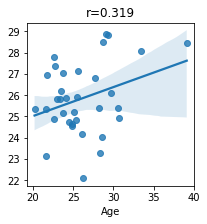

aal


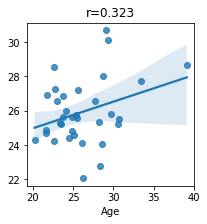

allen


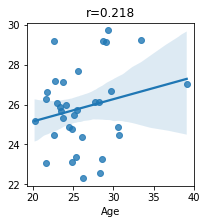

craddock


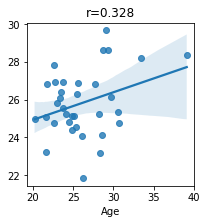

In [251]:
res = pd.DataFrame()

for a in atlases:
    ts, labels = get_ts(a, plot=False)
    X = calculate_connectivity(ts, atlas=a, labels=labels, plot=False)
    
    y=df.Age

    pred = cross_val_predict(RidgeCV(), X=X, y=y, cv=LeaveOneOut())
    r = np.corrcoef(y, pred)[0,1]
    
    atlas = a.split('_')[-1]
    print(atlas)
    plt.figure(figsize=(3,3))
    sns.regplot(x=y, y=pred).set(title='r='+str(round(r,3)))
    plt.show()
    
    res.loc['r', atlas] = r 
    

<AxesSubplot:>

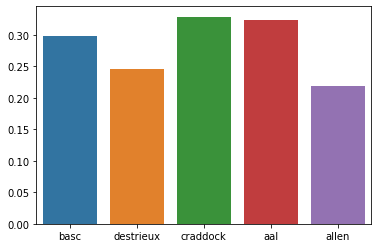

In [252]:
sns.barplot(res)